In [1]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import scipy
import scipy.special
from sklearn.linear_model import LassoCV, LogisticRegressionCV, LinearRegression, Lasso, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
import torch
import torch.nn as nn

In [3]:
def moment_fn(x, test_fn):
    if torch.is_tensor(x):
        with torch.no_grad():
            t1 = torch.cat([torch.ones((x.shape[0], 1)).to(device), x[:, 1:]], dim=1)
            t0 = torch.cat([torch.zeros((x.shape[0], 1)).to(device), x[:, 1:]], dim=1)
    else:
        t1 = np.hstack([np.ones((x.shape[0], 1)), x[:, 1:]])
        t0 = np.hstack([np.zeros((x.shape[0], 1)), x[:, 1:]])
    return test_fn(t1) - test_fn(t0)

In [4]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

In [5]:
from sklearn.linear_model import LassoCV

def get_reg_fn(X, y):
    est = LassoCV(max_iter=10000, random_state=123).fit(X, y)
    return lambda: Lasso(alpha=est.alpha_, max_iter=10000, random_state=123)

In [6]:
from debiased import DebiasedMoment
from advreisz.linear import SparseLinearAdvRiesz

def get_splin_fn(X):
    return lambda: SparseLinearAdvRiesz(moment_fn,
                                        featurizer=Pipeline([('p', PolynomialFeatures(degree=2, include_bias=False)),
                                                             ('s', StandardScaler()),
                                                             ('cnt', PolynomialFeatures(degree=1, include_bias=True))]),
                                        n_iter=50000, lambda_theta=0.01, B=10,
                                        tol=0.00001)

In [7]:
from advreisz.kernel import AdvNystromKernelReisz
from utilities import AutoKernel, prod_kernel

# advkernel_fn = lambda: AdvKernelReisz(kernel=AutoKernel(type='var'), regm=6e-4, regl=1e-4)

def get_advnyskernel_fn(X):
    est = AdvNystromKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]),
                                regm='auto', regl='auto', n_components=100, random_state=123)
    reg = est.opt_reg(X)
    print(est.scores_)
    print(reg)
    return lambda: AdvNystromKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]),
                                         regm=6*reg, regl=reg, n_components=100, random_state=123)

In [8]:
from advreisz.kernel import AdvKernelReisz
from utilities import AutoKernel, prod_kernel

# advkernel_fn = lambda: AdvKernelReisz(kernel=AutoKernel(type='var'), regm=6e-4, regl=1e-4)

def get_advkernel_fn(X):
    est = AdvKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regm='auto', regl='auto')
    reg = est.opt_reg(X)
    print(est.scores_)
    print(reg)
    return lambda: AdvKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regm=6*reg, regl=reg)

In [9]:
from advreisz.kernel import NystromKernelReisz
from utilities import AutoKernel, prod_kernel

# kernel_fn = lambda: KernelReisz(kernel=AutoKernel(type='var'), regl=6e-2)

def get_nyskernel_fn(X):
    est = NystromKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]),
                             regl='auto', n_components=100, random_state=123)
    reg = est.opt_reg(X)
    print(est.scores_)
    print(reg)
    return lambda: NystromKernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]),
                                      regl=reg, n_components=100, random_state=123)

In [10]:
from advreisz.kernel import KernelReisz
from utilities import AutoKernel, prod_kernel

# kernel_fn = lambda: KernelReisz(kernel=AutoKernel(type='var'), regl=6e-2)

def get_kernel_fn(X):
    est = KernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regl='auto')
    reg = est.opt_reg(X)
    print(est.scores_)
    print(reg)
    return lambda: KernelReisz(kernel=lambda X, Y=None: prod_kernel(X, Y=Y, gamma=1.0/X.shape[1]), regl=reg)

In [11]:
from utilities import PluginRR

def get_lg_plugin_fn(X):
    clf = LogisticRegressionCV(cv=3, max_iter=10000, random_state=123)
    C_ = clf.fit(X[:, 1:], X[:, 0]).C_[0]
    return lambda: PluginRR(model_t=LogisticRegression(C=C_, max_iter=10000, random_state=123),
                            min_propensity=0)


def get_rf_plugin_fn(X):
    gcv = GridSearchCV(RandomForestClassifier(bootstrap=True, random_state=123),
                       param_grid={'max_depth': [3, None],
                                   'min_samples_leaf': [10, 50]},
                       scoring='r2',
                       cv=5)
    best_model = clone(gcv.fit(X[:, 1:], X[:, 0]).best_estimator_)
    return lambda: PluginRR(model_t=best_model, min_propensity=0)

In [49]:
from advreisz.ensemble import AdvEnsembleReisz

def get_rf_fn(X):
    return lambda: AdvEnsembleReisz(moment_fn=moment_fn, max_abs_value=15, degree=1)

In [23]:
from utilities import FitParamsWrapper
from advreisz.deepreisz import AdvReisz


device = None #torch.cuda.current_device() if torch.cuda.is_available() else None

# Returns a deep model for the reisz representer
def get_learner(n_t, n_hidden, p):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.LeakyReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

# Returns a deep model for the test functions
def get_adversary(n_z, n_hidden, p):
    return nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.ReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                         nn.Dropout(p=p), nn.Linear(n_hidden, 1))

print("GPU:", torch.cuda.is_available())

def get_agmm_fn(X):
    return lambda: FitParamsWrapper(AdvReisz(get_learner(10, 100, 0.),
                                             get_adversary(10, 100, 0.),
                                             moment_fn),
                                   val_fr=.2,
                                   preprocess_epochs=200,
                                   earlystop_rounds=100,
                                   store_test_every=20,
                                   learner_lr=1e-4, adversary_lr=1e-4,
                                   learner_l2=6e-4, adversary_l2=1e-4,
                                   n_epochs=1000, bs=100,
                                   logger=None, model_dir=str(Path.home()), device=device, verbose=1)

GPU: True


In [50]:
import pandas as pd

n_splits = 1
res = {}
for q in np.arange(0, 6):
    res[f'q={q}'] = {}
    print(f'Quintile={q}')
    df = pd.read_csv(f'401k/quintile{q}_trimmed.csv', index_col=0)
    y = df['Y'].values
    X = df[['D'] + [f'X{i}' for i in np.arange(1, 10)]].values
    
    # scale data
    y = y.astype(np.double)
    X = X.astype(np.double)
    X[:, 1:5] = StandardScaler().fit_transform(X[:, 1:5])
    y_scale = np.std(y)
    y = y / y_scale
    
    # shuffle data
    inds = np.arange(X.shape[0])
    np.random.seed(123)
    np.random.shuffle(inds)
    X, y = X[inds].copy(), y[inds].copy()

    # filter extrement propensities
    clf = LogisticRegressionCV(cv=5, max_iter=10000, random_state=123).fit(X[:, 1:], X[:, 0])
    prop = clf.predict_proba(X[:, 1:])
    filt = (prop[:, 1] <= .9) & (prop[:, 1] >= .1)
    print(X.shape[0], np.sum(filt))
    X, y = X[filt], y[filt]

    for name, get_reisz_fn in [
                               ('splin', get_splin_fn),
                               ('advrkhs', get_advkernel_fn),
                               ('rkhs', get_kernel_fn),
                               ('nys_advrkhs', get_advnyskernel_fn),
                               ('nys_rkhs', get_nyskernel_fn),
                               ('plugin_lg', get_lg_plugin_fn),
                               ('plugin_rf', get_rf_plugin_fn),
                               ('advnnet', get_agmm_fn),
                               ('advrf', get_rf_fn)
                                ]:
        est = DebiasedMoment(moment_fn=moment_fn,
                             get_reisz_fn=get_reisz_fn,
                             get_reg_fn=get_reg_fn, n_splits=n_splits)
        est.fit(X, y)
        p, s, l, u = est.avg_moment()
        res[f'q={q}'][name] = {'point': p * y_scale, 'stderr': s * y_scale,
                               'lower': l * y_scale, 'upper': u * y_scale}
        p, s, l, u = est.avg_moment(tmle=True)
        res[f'q={q}'][f'{name}_tmle'] = {'point': p * y_scale, 'stderr': s * y_scale,
                                         'lower': l * y_scale, 'upper': u * y_scale}

    print(res[f'q={q}'])
    res[f'q={q}'] = pd.DataFrame(res[f'q={q}']).transpose()
res = pd.concat(res)

Quintile=0
9848 9804
{'advrf': {'point': 8178.252869765786, 'stderr': 1198.4291512690186, 'lower': 5829.084846894593, 'upper': 10527.42089263698}, 'advrf_tmle': {'point': 8197.081137393985, 'stderr': 1197.9268375907916, 'lower': 5848.897752812916, 'upper': 10545.264521975054}}
Quintile=1
1970 1970
{'advrf': {'point': 3651.0913929475505, 'stderr': 901.6355951084458, 'lower': 1882.8311429092892, 'upper': 5419.351642985812}, 'advrf_tmle': {'point': 3672.3732047544786, 'stderr': 901.8488302018515, 'lower': 1903.694764549782, 'upper': 5441.051644959176}}
Quintile=2
1970 1970
{'advrf': {'point': 1627.1526897209499, 'stderr': 1670.9832619480676, 'lower': -1649.9287571651992, 'upper': 4904.234136607099}, 'advrf_tmle': {'point': 1689.1396176485764, 'stderr': 1670.4562693099783, 'lower': -1586.9083073368715, 'upper': 4965.187542634024}}
Quintile=3
1970 1970
{'advrf': {'point': 5076.53054035264, 'stderr': 1335.116777404723, 'lower': 2458.140206772254, 'upper': 7694.920873933026}, 'advrf_tmle': {'

In [52]:
res_f = res.reset_index()
res_d = {}
for q in range(6):
    res_d[f'q={q}' if q>0 else 'all'] = {method: "{:.2f} ({:.2f})".format(res.loc[(f'q={q}', method), 'point'],
                                                        res.loc[(f'q={q}', method), 'stderr'])
                                         for method in np.unique(res_f['level_1'].values)}        
res_d = pd.DataFrame(res_d)
res_d

,all,q=1,q=2,q=3,q=4,q=5
advrf,8178.25 (1198.43),3651.09 (901.64),1627.15 (1670.98),5076.53 (1335.12),9781.64 (2196.20),18045.80 (4607.34)
advrf_tmle,8197.08 (1197.93),3672.37 (901.85),1689.14 (1670.46),5080.15 (1334.95),9765.30 (2195.67),18078.20 (4607.06)


In [58]:
import joblib

joblib.dump(res_d, f'401k_res_n_splits_{n_splits}.jbl')

['401k_res_n_splits_1.jbl']

In [59]:
print(res_d[['all', 'q=1', 'q=2']].to_latex(float_format=lambda x: f'{x:.2f}'))

\begin{tabular}{llll}
\toprule
{} &                all &               q=1 &                q=2 \\
\midrule
advrkhs        &  7780.32 (1148.31) &  3581.66 (886.33) &  1394.94 (1525.58) \\
advrkhs\_tmle   &  7812.02 (1148.36) &  3588.73 (886.50) &  1442.82 (1525.74) \\
rkhs           &  7666.88 (1094.32) &  3459.64 (833.86) &  1099.58 (1569.98) \\
rkhs\_tmle      &  7702.31 (1094.42) &  3449.67 (833.67) &  1153.98 (1570.44) \\
splin          &  7797.38 (1040.23) &  3765.62 (907.54) &  1328.90 (1570.15) \\
splin\_tmle     &  7807.19 (1040.47) &  3774.54 (908.39) &  1345.24 (1570.31) \\
advrkhs        &  7780.32 (1148.31) &  3581.66 (886.33) &  1394.94 (1525.58) \\
advrkhs\_tmle   &  7812.02 (1148.36) &  3588.73 (886.50) &  1442.82 (1525.74) \\
plugin\_lg      &  6185.66 (1354.52) &  3763.84 (994.24) &  1055.13 (1660.50) \\
plugin\_lg\_tmle &  6160.61 (1354.20) &  3765.91 (994.18) &  1082.92 (1660.57) \\
plugin\_rf      &  7479.35 (1080.60) &  3729.77 (817.87) &  1211.21 (1507.66) \\
plug

In [60]:
print(res_d[['q=3', 'q=4', 'q=5']].to_latex(float_format=lambda x: f'{x:.2f}'))

\begin{tabular}{llll}
\toprule
{} &                q=3 &                 q=4 &                 q=5 \\
\midrule
advrkhs        &  4855.22 (1609.45) &  10348.87 (2082.64) &  18917.36 (4666.67) \\
advrkhs\_tmle   &  4874.83 (1609.54) &  10407.10 (2081.33) &  18958.28 (4666.20) \\
rkhs           &  5435.90 (1155.22) &   9997.07 (2049.76) &  18901.46 (4386.96) \\
rkhs\_tmle      &  5482.76 (1155.03) &  10069.74 (2049.13) &  18969.25 (4386.63) \\
splin          &  5279.02 (1337.97) &  11190.33 (2187.54) &  20031.69 (4836.11) \\
splin\_tmle     &  5293.18 (1337.79) &  11226.23 (2185.11) &  20053.82 (4834.65) \\
advrkhs        &  4855.22 (1609.45) &  10348.87 (2082.64) &  18917.36 (4666.67) \\
advrkhs\_tmle   &  4874.83 (1609.54) &  10407.10 (2081.33) &  18958.28 (4666.20) \\
plugin\_lg      &  4895.08 (1302.90) &   9287.63 (2327.20) &  17878.75 (4676.24) \\
plugin\_lg\_tmle &  4896.83 (1302.85) &   9290.84 (2327.17) &  17887.27 (4676.08) \\
plugin\_rf      &  4788.29 (1242.76) &   9652.92 (22

In [41]:
print(res_d.to_latex(float_format=lambda x: f'{x:.2f}'))

\begin{tabular}{lllllll}
\toprule
{} &                all &                q=1 &                q=2 &                q=3 &                 q=4 &                 q=5 \\
\midrule
advrkhs          &  7780.32 (1148.31) &   3581.66 (886.33) &  1394.94 (1525.58) &  4855.22 (1609.45) &  10348.87 (2082.64) &  18917.36 (4666.67) \\
advrkhs\_tmle     &  7812.02 (1148.36) &   3588.73 (886.50) &  1442.82 (1525.74) &  4874.83 (1609.54) &  10407.10 (2081.33) &  18958.28 (4666.20) \\
rkhs             &  7666.88 (1094.32) &   3459.64 (833.86) &  1099.58 (1569.98) &  5435.90 (1155.22) &   9997.07 (2049.76) &  18901.46 (4386.96) \\
rkhs\_tmle        &  7702.31 (1094.42) &   3449.67 (833.67) &  1153.98 (1570.44) &  5482.76 (1155.03) &  10069.74 (2049.13) &  18969.25 (4386.63) \\
splin            &  7797.38 (1040.23) &   3765.62 (907.54) &  1328.90 (1570.15) &  5279.02 (1337.97) &  11190.33 (2187.54) &  20031.69 (4836.11) \\
splin\_tmle       &  7807.19 (1040.47) &   3774.54 (908.39) &  1345.24 (1570.31) 

In [156]:
import pandas as pd

df = pd.read_csv(f'401k/quintile1_trimmed.csv', index_col=0)
y = df['Y'].values
X = df[['D'] + [f'X{i}' for i in np.arange(1, 10)]].values
y = y.astype(np.double)
X = X.astype(np.double)

# clf = RandomForestClassifier(bootstrap=True, min_samples_leaf=5).fit(X[:, 1:], X[:, 0])
# prop = clf.predict_proba(X[:, 1:])
# filt = (prop[:, 1] <= .9) & (prop[:, 1] >= .1)
# print(X.shape[0], np.sum(filt))
# X, y = X[filt], y[filt]

X[:, 1:5] = StandardScaler().fit_transform(X[:, 1:5])
y_scale = np.std(y)
y = y / y_scale
inds = np.arange(X.shape[0])
np.random.seed(123)
np.random.shuffle(inds)
X, y = X[inds].copy(), y[inds].copy()

In [157]:
est = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                     get_reisz_fn=get_advkernel_fn, n_splits=1)
est.fit(X, y)
print([i * y_scale for i in est.avg_moment()])
print([i * y_scale for i in est.avg_moment(tmle=True)])

[3581.6611524055743, 886.3341444347128, 1843.4096410873371, 5319.912663723811]
[3588.7276388264386, 886.4982733947618, 1850.154242793901, 5327.301034858976]


In [158]:
print([i * y_scale for i in est.avg_moment(tmle=True)])

[3588.7276388264386, 886.4982733947618, 1850.154242793901, 5327.301034858976]


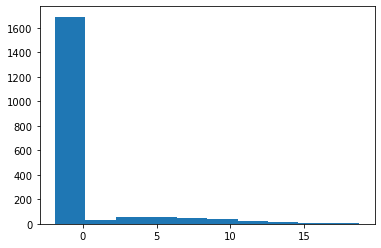

In [159]:
plt.hist(est.reisz_models_[0].predict(X))
plt.show()

In [160]:
print(est.reisz_models_[0].scores_)

[5929.062983542529, 13148.093262485821, 1015.8691957106873, 424.7404779759171, 25.132943419432443, 0.665262465834437, -2.3096214782437106e-05, 11783.0454577003, 46169.959596986155, 65120.70669147864, 68814.37576636716, 69008.78683626204, 69012.64075743068, 69012.69855578215]


In [161]:
print(est.reisz_models_[0].regl_)

3.455107294592218e-05


In [162]:
kest = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                     get_reisz_fn=get_kernel_fn, n_splits=1)
kest.fit(X, y)
print([i * y_scale for i in kest.avg_moment()])
print([i * y_scale for i in kest.avg_moment(tmle=True)])

[3548.123161623499, 951.165144356365, 1682.7270691090164, 5413.519254137981]
[3550.469466009094, 951.1953484612412, 1685.0141381246567, 5415.924793893531]


In [163]:
print(kest.reisz_models_[0].scores_)

[-8.582181791610026, -8.568752077816722, -7.30161598870282, -9.29849183453675, -10.103027078375462, -9.653674389523664, -8.677850092762311, -8.231716556434703, -5.880250316306816, -1.8279555844612512, -0.30344520976230405, -0.03932795563909257]


In [164]:
print(kest.reisz_models_[0].regl_)

4.328761281083062e-05


In [165]:
from utilities import PluginRR

rfest = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                     get_reisz_fn=get_rf_plugin_fn, n_splits=1)
rfest.fit(X, y)
print([i * y_scale for i in rfest.avg_moment()])
print([i * y_scale for i in rfest.avg_moment(tmle=True)])

[3716.3684185039983, 616.0653245261583, 2508.1598798254627, 4924.576957182534]
[4226.297544979248, 616.2127978850544, 3017.7997860437813, 5434.795303914715]


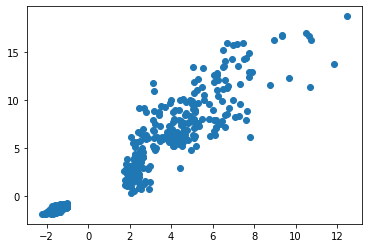

In [166]:
plt.scatter(rfest.reisz_models_[0].predict(X), est.reisz_models_[0].predict(X))
plt.show()

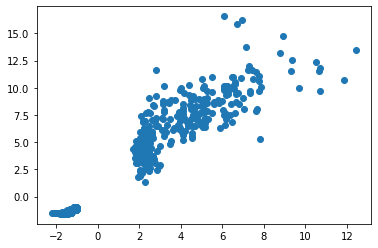

In [167]:
plt.scatter(rfest.reisz_models_[0].predict(X), kest.reisz_models_[0].predict(X))
plt.show()

In [16]:
from utilities import PluginRR

nnest = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                       get_reisz_fn=get_agmm_fn, n_splits=1)
nnest.fit(X, y)
print([i * y_scale for i in nnest.avg_moment()])
print([i * y_scale for i in nnest.avg_moment(tmle=True)])

Splitting
Epoch #0
Epoch #1
Epoch #2
Epoch #3
Epoch #4
Epoch #5
Epoch #6
Epoch #7
Epoch #8
Epoch #9
Epoch #10
Epoch #11
Epoch #12
Epoch #13
Epoch #14
Epoch #15
Epoch #16
Epoch #17
Epoch #18
Epoch #19
Epoch #20
Epoch #21
Epoch #22
Epoch #23
Epoch #24
Epoch #25
Epoch #26
Epoch #27
Epoch #28
Epoch #29
Epoch #30
Epoch #31
Epoch #32
Epoch #33
Epoch #34
Epoch #35
Epoch #36
Epoch #37
Epoch #38
Epoch #39
Epoch #40
Epoch #41
Epoch #42
Epoch #43
Epoch #44
Epoch #45
Epoch #46
Epoch #47
Epoch #48
Epoch #49
Epoch #50
Epoch #51
Epoch #52
Epoch #53
Epoch #54
Epoch #55
Epoch #56
Epoch #57
Epoch #58
Epoch #59
Epoch #60
Epoch #61
Epoch #62
Epoch #63
Epoch #64
Epoch #65
Epoch #66
Epoch #67
Epoch #68
Epoch #69
Epoch #70
Epoch #71
Epoch #72
Epoch #73
Epoch #74
Epoch #75
Epoch #76
Epoch #77
Epoch #78
Epoch #79
Epoch #80
Epoch #81
Epoch #82
Epoch #83
Epoch #84
Epoch #85
Epoch #86
Epoch #87
Epoch #88
Epoch #89
Epoch #90
Epoch #91
Epoch #92
Epoch #93
Epoch #94
Epoch #95
Epoch #96
Epoch #97
Epoch #98
Epoch #99


Validation moment violation: 0.12551098
Epoch #125
Validation moment violation: 0.099698626
Epoch #126
Validation moment violation: 0.08942034
Epoch #127
Validation moment violation: 0.06535544
Epoch #128
Validation moment violation: 0.04728854
Epoch #129
Validation moment violation: 0.028807156
Epoch #130
Validation moment violation: 0.024270833
Epoch #131
Validation moment violation: 0.025504481
Epoch #132
Validation moment violation: 0.026067453
Epoch #133
Validation moment violation: 0.025599942
Epoch #134
Validation moment violation: 0.027361225
Epoch #135
Validation moment violation: 0.026907021
Epoch #136
Validation moment violation: 0.026312867
Epoch #137
Validation moment violation: 0.026986912
Epoch #138
Validation moment violation: 0.026854992
Epoch #139
Validation moment violation: 0.027997399
Epoch #140
Validation moment violation: 0.039040014
Epoch #141
Validation moment violation: 0.048212502
Epoch #142
Validation moment violation: 0.049349952
Epoch #143
Validation momen

Validation moment violation: 0.017532049
Epoch #284
Validation moment violation: 0.016241653
Epoch #285
Validation moment violation: 0.013189494
Epoch #286
Validation moment violation: 0.01138599
Epoch #287
Validation moment violation: 0.01032397
Epoch #288
Validation moment violation: 0.010868609
Epoch #289
Validation moment violation: 0.011960357
Epoch #290
Validation moment violation: 0.012280311
Epoch #291
Validation moment violation: 0.021372776
Epoch #292
Validation moment violation: 0.016736489
Epoch #293
Validation moment violation: 0.028192602
Epoch #294
Validation moment violation: 0.031881515
Epoch #295
Validation moment violation: 0.025060482
Epoch #296
Validation moment violation: 0.028359238
Epoch #297
Validation moment violation: 0.014785212
Epoch #298
Validation moment violation: 0.011926315
Epoch #299
Validation moment violation: 0.011573378
Epoch #300
Validation moment violation: 0.011033472
Epoch #301
Validation moment violation: 0.021411832
Epoch #302
Validation mom

In [18]:
from utilities import PluginRR

rfest = DebiasedMoment(moment_fn=moment_fn, get_reg_fn=get_reg_fn,
                     get_reisz_fn=get_rf_plugin_fn, n_splits=1)
rfest.fit(X, y)
print([i * y_scale for i in rfest.avg_moment()])
print([i * y_scale for i in rfest.avg_moment(tmle=True)])

[18433.615497287286, 4625.212081286994, 9362.787690768644, 27504.44330380593]
[18514.11083576608, 4624.933717372328, 9443.828948243825, 27584.39272328834]


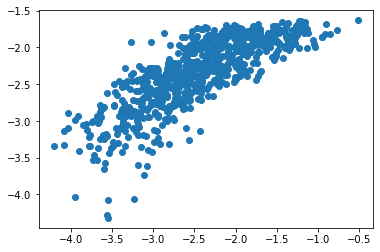

In [22]:
plt.scatter(rfest.reisz_models_[0].predict(X), nnest.reisz_models_[0].predict(X))
plt.show()